In [1]:
from __future__ import print_function
%matplotlib inline
import matplotlib.pylab as plt
import sys, os, glob
import numpy as np

# set some nicer plotting options
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

In [2]:
from pyspark.sql import SQLContext, HiveContext

In [3]:
hc = HiveContext(sc)

In [4]:
!hadoop fs -ls /user/roskarr/twitter

Picked up _JAVA_OPTIONS: -Xmx10G -Xms256m -XX:ParallelGCThreads=5
15/11/13 16:35:01 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Found 7 items
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:21 /user/roskarr/twitter/2014_05
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:26 /user/roskarr/twitter/2014_06
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:31 /user/roskarr/twitter/2014_07
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:37 /user/roskarr/twitter/2014_09
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:43 /user/roskarr/twitter/2014_10
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:49 /user/roskarr/twitter/2014_11
drwxr-xr-x   - roskarr supergroup          0 2015-11-02 16:50 /user/roskarr/twitter/2014_12


In [5]:
!hadoop fs -du -h /user/roskarr/twitter

Picked up _JAVA_OPTIONS: -Xmx10G -Xms256m -XX:ParallelGCThreads=5
15/11/13 16:35:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
55.1 G  /user/roskarr/twitter/2014_05
31.7 G  /user/roskarr/twitter/2014_06
51.0 G  /user/roskarr/twitter/2014_07
59.6 G  /user/roskarr/twitter/2014_09
61.9 G  /user/roskarr/twitter/2014_10
62.0 G  /user/roskarr/twitter/2014_11
12.1 G  /user/roskarr/twitter/2014_12


We'll load the data off the disk, but only for the last three months of the year. 

In [6]:
%%time
data = hc.read.parquet('/user/roskarr/twitter/2014_1*')

CPU times: user 9 ms, sys: 5 ms, total: 14 ms
Wall time: 30.3 s


`data` is now a `DataFrame` object, which is essentially a collection of `Row` objects. Each `Row` object contains data for whatever columns are defined in the `DataFrame`. Here is a critical difference between `DataFrames` and `RDD`s: each column has an associated data type. While in dealing with an `RDD` we relied on Python to convert types, here each column has a specified data type. This means that a) we have to be a bit more careful about what we are doing and b) the execution engine can optimize our calculations because the data is no longer a black box. 

### Importing libraries and types for `DataFrame` API

In [7]:
import pyspark.sql.functions as func
from pyspark.sql import Row, Window
from pyspark.sql.types import IntegerType, ArrayType, StringType, NullType, LongType, StructField, StructType, DateType, DataType, DateConverter, DatetimeConverter, TimestampType, BooleanType
import datetime

### Custom functions to extract hashtags

The twitter data is rather complex and includes many different kinds of fields that we will not be using here. We will also change the format of the time string to something that Spark will have an easier time understanding. 

In [8]:
convert_date_string = func.udf(lambda date_string: datetime.date.strftime(datetime.datetime.strptime(date_string, '%a %b %d %H:%M:%S +0000 %Y'),'%Y-%m-%d %H:%M:%S'), StringType())

In [9]:
# make UDF for converting the date string to a datetime object
datetime_udf = func.udf(lambda date_string: datetime.strptime(date_string, '%a %b %d %H:%M:%S +0000 %Y'), DateType())

In [10]:
hash_text_udf = func.udf(lambda row: [r.text for r in row], returnType=ArrayType(StringType()))

In [11]:
Npartitions = sc.defaultParallelism*5

In [12]:
# only keep the tweets with at least one hashtag
hashtag_df = (data.select('created_at', 'entities.hashtags')
                .filter(func.size('hashtags') > 0)
                .withColumn('hash_text', hash_text_udf('hashtags'))
                .select(convert_date_string('created_at').alias('date'), func.explode('hash_text').alias('hashtag'))
                .withColumn('hashtag', func.lower(func.col('hashtag')))
                .repartition(Npartitions))
hashtag_df.cache()

DataFrame[date: string, hashtag: string]

#### A look at the raw data

We now have a `DataFrame` consisting of a timestamp and hashtag. The `show()` method is extremelly useful here -- it functions like `take()` for an RDD, but it formats the output nicely so it's more easily readable. 

In [13]:
hashtag_df.show(truncate=False)

+-------------------+-----------------------+
|date               |hashtag                |
+-------------------+-----------------------+
|2014-10-01 07:51:33|android                |
|2014-10-01 11:32:41|windows                |
|2014-10-02 03:23:51|video                  |
|2014-10-02 14:59:46|vishalbhardwaj         |
|2014-10-03 01:51:51|3yearsofalwaysinmyheart|
|2014-10-03 15:04:05|kobane                 |
|2014-10-03 15:04:55|10月4日は跡部景吾様御生誕祭        |
|2014-10-04 03:11:57|startups               |
|2014-10-04 13:15:49|af10                   |
|2014-10-04 21:32:53|goldbar                |
|2014-10-05 14:08:06|mixnmatch              |
|2014-10-05 14:08:44|votevampsvevo          |
|2014-10-06 02:56:39|ساديه                  |
|2014-10-06 05:48:59|바카라사이트씽크풀              |
|2014-10-06 18:02:55|yahalashow             |
|2014-10-07 16:23:04|steelers               |
|2014-10-07 21:01:06|rt                     |
|2014-10-07 21:01:58|vaga                   |
|2014-10-08 16:38:12|depechemode  

Underneath the `DataFrame` object is an RDD of `Row` objects, which are just containers used by `DataFrame`:

In [14]:
hashtag_df.take(5)

[Row(date=u'2014-10-01 07:51:33', hashtag=u'android'),
 Row(date=u'2014-10-01 11:32:41', hashtag=u'windows'),
 Row(date=u'2014-10-02 03:23:51', hashtag=u'video'),
 Row(date=u'2014-10-02 14:59:46', hashtag=u'vishalbhardwaj'),
 Row(date=u'2014-10-03 01:51:51', hashtag=u'3yearsofalwaysinmyheart')]

In `DataFrame`s, you can think of the `select` method to be analogous to `map` in an `RDD`. In its simplest form, `select` is just used to, well, trim down the `DataFrame` to the columns that are needed: 

In [15]:
hashtag_df.select('date').show(5)

+-------------------+
|               date|
+-------------------+
|2014-10-01 07:51:33|
|2014-10-01 11:32:41|
|2014-10-02 03:23:51|
|2014-10-02 14:59:46|
|2014-10-03 01:51:51|
+-------------------+
only showing top 5 rows



You can select multiple columns: 

In [16]:
hashtag_df.select('date', 'hashtag').show(5)

+-------------------+--------------------+
|               date|             hashtag|
+-------------------+--------------------+
|2014-10-01 07:51:33|             android|
|2014-10-01 11:32:41|             windows|
|2014-10-02 03:23:51|               video|
|2014-10-02 14:59:46|      vishalbhardwaj|
|2014-10-03 01:51:51|3yearsofalwaysinm...|
+-------------------+--------------------+
only showing top 5 rows



In addition, we can pass functions to `select` that will operate on existing columns and define a new column. For example, lets use the `month` function to extract the month from the date string: 

In [17]:
hashtag_df.select('hashtag', func.month('date')).show(5)

+--------------------+-----------+
|             hashtag|month(date)|
+--------------------+-----------+
|             android|         10|
|             windows|         10|
|               video|         10|
|      vishalbhardwaj|         10|
|3yearsofalwaysinm...|         10|
+--------------------+-----------+
only showing top 5 rows



If some extra functionality is needed, we can define a custom "user defined function" (UDF) that uses the standard python interpreter. The function has to be registered as a UDF using [`pyspark.sql.functions.udf`](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.udf). For example: 

In [18]:
def string_length(x):
    return len(x)

string_length_udf = func.udf(string_length, LongType())

In [19]:
hashtag_df.select('hashtag', string_length_udf('hashtag')).show(5)

+--------------------+--------------------------------+
|             hashtag|PythonUDF#string_length(hashtag)|
+--------------------+--------------------------------+
|             android|                               7|
|             windows|                               7|
|               video|                               5|
|      vishalbhardwaj|                              14|
|3yearsofalwaysinm...|                              23|
+--------------------+--------------------------------+
only showing top 5 rows



### `DataFrame` superpower:  `groupBy`

`DataFrame`'s `groupBy()` method to allows you to collect together rows that share a common value. This is a powerful method that allows you to perform aggregations on your data quickly. It can serve as a replacement to `reduceByKey` that is used on `RDD`s and requires considerably less wrangling with keys and values. 

This is also where things get a little confusing: unlike other `DataFrame` and `RDD` methods, `groupBy` doesn't return another `DataFrame`. Instead, it returns a `GroupedData` object, which has very limited functionality. It can *only* perform the dedicated aggregation functions `avg`, `count`, `max`, `mean`, `min`, and `sum`. You can specify a column (or columns) for the aggregation for all of these except `count`, which just counts the number of rows in each group. These methods all return another `DataFrame`, so the `GroupedData` is a sort of intermediate stage. 

Here, we will try to find out how many hashtags are tweeted each minute, so we will first create a custom UDF that calculates minute-of-the-year for each hashtag. Then we will use `groupBy` aggregation methods to obtain counts. 

In [20]:
minute_of_the_year = (func.dayofyear('date')*60*24 + func.hour('date')*60 + func.minute('date')).alias('moy')

In [21]:
moy_df = hashtag_df.select('hashtag', minute_of_the_year)

In [22]:
moy_df.show(5)

+--------------------+------+
|             hashtag|   moy|
+--------------------+------+
|             android|395031|
|             windows|395252|
|               video|396203|
|      vishalbhardwaj|396899|
|3yearsofalwaysinm...|397551|
+--------------------+------+
only showing top 5 rows



In [23]:
moy_group = moy_df.groupBy('moy')
moy_group

Note that `moy_group` is a `GroupedData` instance - it contains groups of rows that all have the same value of `'moy'`. Calling `count()` will give us back a `DataFrame`:

In [24]:
moy_count = moy_group.count()
moy_count

DataFrame[moy: int, count: bigint]

In [25]:
moy_count.show()

+------+-----+
|   moy|count|
+------+-----+
|418031|  846|
|397631| 1064|
|466431| 1020|
|443631| 1032|
|487631| 1309|
|483231| 1031|
|438031|  744|
|411631| 1006|
|396431|  832|
|400231|  871|
|405831| 1017|
|423031| 1178|
|426431| 1032|
|403831|  875|
|402231|  833|
|411431| 1267|
|460031| 1080|
|472831|  826|
|406031|  960|
|420431|  929|
+------+-----+
only showing top 20 rows



We can collect this "reduced" data into a Pandas dataframe and plot it: 

In [26]:
moy_data = moy_count.toPandas()

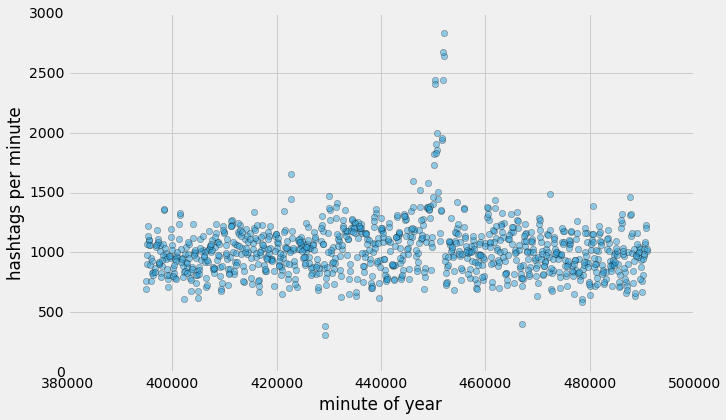

In [27]:
fig, ax = plt.subplots()
plt.plot(moy_data['moy'][:1000], moy_data['count'][:1000], 'o', alpha=.5)
plt.xlabel('minute of year'); plt.ylabel('hashtags per minute')

For fun, lets do a quick aside and check for any obvious periods in there...

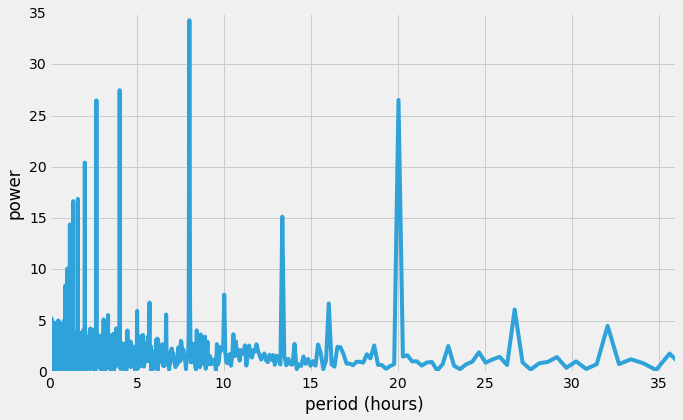

In [28]:
import scipy.fftpack

N = len(moy_data['count'])
T = (moy_data['moy'].max() - moy_data['moy'].min())/N

yf = scipy.fftpack.fft(moy_data['count'])

xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(1./xf/60.,2.0/N * np.abs(yf[0:N/2]))
ax.set_xlim(0,36)
ax.set_xlabel('period (hours)'); ax.set_ylabel('power');

A lot of structure in there! some of it might be harmonics, but looking into periodicity on Twitter [has been done before](http://theory.stanford.edu/~nmishra/Papers/groupChatsOnTwitter.pdf) (obviously).

### Simple word count revisited

OK, back to Spark. Now that we have a `DataFrame` consisting of `(timestamp, hashtag)` columns, lets do a simple word count using the `DataFrame` API. To accomplish this, we'll once again use the `groupBy` method of the `DataFrame`:

In [29]:
%%time 
hashtag_df.groupBy('hashtag').count().sort('count', ascending=False).show(25, False)

+--------------------------+-------+
|hashtag                   |count  |
+--------------------------+-------+
|mtvstars                  |2415609|
|emabiggestfans1d          |1563014|
|emabiggestfansjustinbieber|1463962|
|vote5sos                  |1164349|
|votefifthharmony          |1074152|
|kcaargentina              |747380 |
|gameinsight               |695806 |
|android                   |500114 |
|rt                        |417169 |
|teamfollowback            |403850 |
|تطبيق_قرآنى               |393429 |
|رتويت                     |365394 |
|androidgames              |352950 |
|rtした人全員フォローする             |332244 |
|الهلال                    |324080 |
|amas                      |311910 |
|sougofollow               |305094 |
|follow                    |298020 |
|相互フォロー                    |295854 |
|ipad                      |293422 |
|الرياض                    |283517 |
|السعودية                  |278007 |
|ff                        |252875 |
|ipadgames                 |252507 |
|

In [30]:
%%time
res = (hashtag_df.map(lambda r: (r.hashtag, 1))
           .reduceByKey(lambda a,b:a+b)
           .sortBy(lambda (k,count): count, ascending=False)).take(25)
for x in res: 
    print(x[0], x[1])

mtvstars 2415609
emabiggestfans1d 1563014
emabiggestfansjustinbieber 1463962
vote5sos 1164349
votefifthharmony 1074152
kcaargentina 747380
gameinsight 695806
android 500114
rt 417169
teamfollowback 403850
تطبيق_قرآنى 393429
رتويت 365394
androidgames 352950
rtした人全員フォローする 332244
الهلال 324080
amas 311910
sougofollow 305094
follow 298020
相互フォロー 295854
ipad 293422
الرياض 283517
السعودية 278007
ff 252875
ipadgames 252507
كنز_المسلم 250930
CPU times: user 375 ms, sys: 123 ms, total: 498 ms
Wall time: 28.4 s


 As we can see here, there are lots os languages represented on Twitter! This is very interesting by itself, but for now lets focus on just plain ascii hash tags which we are more likely to understand: 

In [31]:
# define a helper UDF that can be used to filter non-ascii hashtags
def is_ascii(s):
    return all(ord(c) > 0 and ord(c) < 128 for c in s)
is_ascii_udf = func.udf(is_ascii, BooleanType())

In [32]:
hashtag_df = hashtag_df.filter(is_ascii_udf('hashtag'))

### Daily hashtag trends

Now lets do something slightly more complicated and incorporate the time data into our analysis. 

To get information about daily hashtag usage, we must first convert the date string into a number representing day of the year. The [Spark DataFrame functions module](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) provides a function [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) that will do this for us and we can use it just like we used the User Defined Functions (UDFs) above. 

In [33]:
daily_hashtag = hashtag_df.select(func.month('date').alias('month'),
                                  func.weekofyear('date').alias('week'),
                                  func.dayofyear('date').alias('day'), 
                                  'hashtag')
daily_hashtag.show(5)

+-----+----+---+--------------------+
|month|week|day|             hashtag|
+-----+----+---+--------------------+
|   10|  40|274|             android|
|   10|  40|274|             windows|
|   10|  40|275|               video|
|   10|  40|275|      vishalbhardwaj|
|   10|  40|276|3yearsofalwaysinm...|
+-----+----+---+--------------------+
only showing top 5 rows



We can now use the same technique as above using `groupBy` to get daily counts for each hashtag. Since we want to satisfy two conditions (counts per day and counts per hashtag), we simply give `groupBy` two columns:

In [34]:
day_counts = daily_hashtag.groupby('day', 'hashtag', 'week').count()

In [35]:
%time day_counts.sort('day').count()

CPU times: user 122 ms, sys: 49 ms, total: 171 ms
Wall time: 24.2 s


11160949

#### Important aside concerning `count()` (read this while waiting for the above line to complete)

The use of `count()` here is very confusing -- in the first of the two cells above, `count()` is a method of a [GroupedData](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.GroupedData) object, which performs a counting of items in each group. Our grouping here is defined by week, day, and hashtag, so calling `count()` gives us the number of times a hashtag appears each day of the year (week here has no effect since days are unique anyway). To make it even more confusing, `count()` in this case actually returns a `DataFrame`, with "count" as one of the columns. 

However, we are much more used to seeing `count()` as an `RDD` method! This is done in the second of the two cells above. There, it returns a single number representing the number of elements in the `RDD` (or `DataFrame`), which is much different. 

In [36]:
day_counts.show(5)

+---+------------------+----+-----+
|day|           hashtag|week|count|
+---+------------------+----+-----+
|301|              epic|  44|   40|
|288|                ff|  42| 3813|
|279|1forthemostcountry|  41|    3|
|282|           average|  41|    6|
|302|            anakkl|  44|   80|
+---+------------------+----+-----+
only showing top 5 rows



#### `RDD` analogy:

The same counting of daily occurences of each hashtag can be done with an `RDD` operation using a `map` and `reduceByKey`, though it might look a bit messier: 

In [37]:
# TODO
day_counts_rdd = daily_hashtag.rdd.map(lambda r: ((r.day, r.hashtag, r.week), 1)).reduceByKey(lambda a,b: a+b)

In [38]:
%time day_counts_rdd.sortBy(lambda ((day, hashtag, week), count): day).count()

CPU times: user 425 ms, sys: 138 ms, total: 563 ms
Wall time: 48.6 s


11160949

Wow, that takes way longer! The `DataFrame` API avoids shipping data back and forth to the Python intepreter (and can do some extra optimizations) so the performance difference can be significant, as we can see above. 

Lets make sure that the results are the same by looking up a hashtag in both places:

In [39]:
day_counts_rdd.lookup((274,'retweet',40))

[2204]

In [40]:
day_counts.filter((day_counts.hashtag == 'retweet') & (day_counts.day == 274)).show()

+---+-------+----+-----+
|day|hashtag|week|count|
+---+-------+----+-----+
|274|retweet|  40| 2204|
+---+-------+----+-----+



At this point we should persist `day_counts` in memory since we'll be using it later on. 

In [41]:
day_counts.cache()

DataFrame[day: int, hashtag: string, week: int, count: bigint]

We can get a quick idea of the most popular hashtags by looking at the weekly averages of daily hashtag counts:

In [49]:
(day_counts.groupBy('week', 'hashtag')
           .avg('count')
           .sort('avg(count)', ascending=False)
           .show(20))

+----+--------------------+------------------+
|week|             hashtag|        avg(count)|
+----+--------------------+------------------+
|  45|            vote5sos|          159567.0|
|  45|    votefifthharmony|149373.85714285713|
|  47|            mtvstars|130512.57142857143|
|  48|            mtvstars| 97469.71428571429|
|  49|            mtvstars| 71965.85714285714|
|  45|    emabiggestfans1d| 65711.57142857143|
|  46|            mtvstars|           63171.2|
|  45|emabiggestfansjus...| 58197.28571428572|
|  42|    emabiggestfans1d|54077.857142857145|
|  42|emabiggestfansjus...| 52082.28571428572|
|  44|    emabiggestfans1d| 49943.57142857143|
|  44|emabiggestfansjus...| 47231.71428571428|
|  46|           murrayftw|37438.666666666664|
|  43|        kcaargentina| 36302.28571428572|
|  43|    emabiggestfans1d|30190.571428571428|
|  43|emabiggestfansjus...| 29586.85714285714|
|  42|        kcaargentina| 25964.14285714286|
|  40|       votevampsvevo|           21236.0|
|  41|    ema

Apparently, the [MTV Europe Music Awards](https://en.wikipedia.org/wiki/2014_MTV_Europe_Music_Awards) happened in late 2014... (and [yet another boy band](https://en.wikipedia.org/wiki/One_Direction) is on the scene?)

## Using `window` functions

### top daily hashtags

Now lets say we want to know the top tweets for each day. This is a non-trivial thing to try and compute using a standard RDD, but the `DataFrame` API gives us ["window"](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) functions that let us do it relatively easily. 

A window function defines how the data should be grouped and ordered. Then, when using either a ranking or analytic function (see the list in the [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html)) we can specify which window to run the function over. 

In this example, we will define a window function, `daily_window`, over the `'day'` column so our data will be grouped by day. Applying `daily_window` to the built-in `rank` function will give us `daily_rank`, a function that will yield a new column `'rank'` that will hold the rank of each hashtag on a given day based on its counts (in descending order).

In the end, this is a fairly complicated operation achieved in just a few lines of code! 

In [44]:
daily_window = Window.partitionBy('day')

In [45]:
daily_rank = (func.rank() # define the basic function
                  .over(daily_window.orderBy(func.desc('count'))) # give the window *over* which rank should be applied
                  .alias('rank')) # name of the new column

In [46]:
(day_counts.select('day', 'count', 'hashtag', daily_rank)
           .filter('rank < 6')
           .show(20))

+---+-----+-------------+----+
|day|count|      hashtag|rank|
+---+-----+-------------+----+
|274| 9880|  gameinsight|   1|
|274| 9179| kcaargentina|   2|
|274| 6675|      android|   3|
|274| 5893| androidgames|   4|
|274| 4618|           rt|   5|
|275|13857| kcaargentina|   1|
|275|13725|  gameinsight|   2|
|275|10093|   1dproposal|   3|
|275| 9774|      android|   4|
|275| 7515| androidgames|   5|
|276|15196|  gameinsight|   1|
|276|14743| kcaargentina|   2|
|276|11497|      android|   3|
|276| 7423| androidgames|   4|
|276| 6806|           ff|   5|
|277|21738|votevampsvevo|   1|
|277|19660| kcaargentina|   2|
|277|15055|  gameinsight|   3|
|277|11135|      android|   4|
|277| 7401| androidgames|   5|
+---+-----+-------------+----+
only showing top 20 rows



### A more complicated `Window` example: calculating the daily standard deviation based on a weekly window

The above list of top daily hashtags is interesting, but it really only uncovers very frequent hashtags (e.g. "ff" for "friend forward" or "rt" for "retweet"). We want to try and identify "world events" and for that we want to detect a rapid *change* in the tweeting pattern. 

One very simple model to do this is to just look at the standard deviation of daily tweets. We want to have some sort of reasonably fine-grained control, so we will look at top hashtags per week. Remember standard deviation is just:

$$\sigma = \sqrt{\frac{1}{N}\sum_i{(x_i-\mu)^2}},$$

where $x_i$ is the daily count of a hashtag, $\mu$ is the weekly average and $N$ is the number of samples (here $N=7$ since there are always seven days in a week). 

So the procedure is something like this: 

1. calculate $\mu$ for each hastag and each week
2. compute the sum and take the square root
3. order tweets for each week in order of decreasing $\sigma$

Using standard `RDD`s, the first step would be the most time consuming -- we would need to do an expensive `reduceByKey` on `(week, hashtag, count)` key-value pairs and then either join this result with the original `RDD` or broadcast it as a lookup-table (depending on its size). 

Using a `DataFrame`, we can instead use a "window" function to do the same thing. 

#### Constructing the window function and calculating $\sigma$

Our procedure to calculate $\sigma$ using a weekly mean is as follows:

1. define a `Window` function that will group the data by hashtag and by week
2. compute `mean_diff` which is the difference between the data point and the weekly mean using the window function
2. calculate `var_arg`, which is just $1/7 
3. use `groupBy` to sum up the `sum_arg` column for each hashtag each week
4. calculate `sigma` by taking the square root of the variance 

In [52]:
# define the window function, partitioned over 'week' and 'hashtag'
weekly_window = Window.partitionBy('week', 'hashtag')

In [53]:
# define the mean_diff function which computes the difference between each data point 'count' 
# and the mean of 'count' over the weekly window (defined above)
mean_diff = day_counts['count'] - func.mean('count').over(weekly_window)

var_arg = 1./7*mean_diff*mean_diff

In [55]:
weekly_stats = (day_counts.withColumn('var_arg', var_arg)
                         .groupBy('week', 'hashtag')
                         .sum('var_arg')
                         .withColumnRenamed('sum(var_arg)', 'variance')
                         .withColumn('stddev', func.sqrt('variance'))
                         .sort('stddev', ascending=False))

In [56]:
weekly_stats.show()

+----+--------------------+--------------------+------------------+
|week|             hashtag|            variance|            stddev|
+----+--------------------+--------------------+------------------+
|  45|            vote5sos|2.996737583968431...|173110.87730031385|
|  45|    votefifthharmony|2.716333743123813...|164813.03780720182|
|  46|           murrayftw| 5.839912011898922E9|  76419.3170075402|
|  46|            mtvstars|  4.50628024953835E9| 67128.83322044522|
|  45|    emabiggestfans1d|2.4444591408138824E9| 49441.47187143484|
|  45|emabiggestfansjus...|1.9072142253450317E9| 43671.66387195514|
|  41|    emabiggestfans1d| 5.615435298361732E8| 23696.90971068112|
|  49|            mtvstars| 5.328185101219162E8|23082.861826946766|
|  41|emabiggestfansjus...| 4.734708501219754E8|21759.385334194885|
|  44|        kcaargentina|3.2434063599967563E8|18009.459625421183|
|  46|            vote5sos|2.2709849277528307E8|15069.787416393208|
|  48|            ferguson| 2.010179525304112E8|

In [57]:
weekly_stats_window = Window.partitionBy('week').orderBy(func.desc('stddev'))

In [59]:
print('Top ten hashtags with highest variation each week')
(weekly_stats.select('week', 'hashtag', 'stddev', 
                     func.rank().over(weekly_stats_window).alias('rank'))
             .filter('rank < 10')
             ).show(150)

Top ten hashtags with highest variation each week
+----+--------------------+------------------+----+
|week|             hashtag|            stddev|rank|
+----+--------------------+------------------+----+
|  40|      followmecarter| 4248.384701437773|   1|
|  40|          1dproposal|3329.9083041841595|   2|
|  40|        kcaargentina| 3225.485788438413|   3|
|  40|  hormonestheseries2| 2207.925141069451|   4|
|  40|       nashsnewvideo|1888.8845839343926|   5|
|  40|         gameinsight|1659.7393427015975|   6|
|  40|       debatenaglobo| 1627.613643167789|   7|
|  40|     sbspopasiabeast|1622.2622101771333|   8|
|  40|                  ff|1599.9488027515167|   9|
|  41|    emabiggestfans1d| 23696.90971068112|   1|
|  41|emabiggestfansjus...|21759.385334194885|   2|
|  41|        kcaargentina| 4302.523236899845|   3|
|  41|  hormonestheseries2|2998.8986413707776|   4|
|  41|  alwayssupportluhan| 2590.285808829184|   5|
|  41|thankyou1dforthewwat| 2133.092839334458|   6|
|  41|       j

A lot of these are pop-culture events and probably PR campaigns, e.g. 'votefifthharmony' and 'vote5sos'. Turns out the MTV Europe Music Awards were happening during November 2014, so these are not surprising. Also, who knew Twitter was so big in Argentina... check out what [kcaaargentina](http://kidschoiceawardsargentina.mundonick.com/) refers to... (We also see another "world event" -- 'halloween' pop up in week 44. 

Interestingly, in week 48 we finally see something that we are after: ["ferguson"](https://en.wikipedia.org/wiki/Ferguson_unrest). This was a huge event covered world-wide and spanned several months -- it actually started in August, but in November the riots returned when the grand jury decided not to indict the police officer who shot Michael Brown. We'll explore this more a bit further down. 

### Plotting the timeseries of hashtag counts

These standard deviation lists we obtained above are nice, but lets actually look at some data. Below we define a simple function for plotting time series data of hashtags. You can specify a single hashtag or a series of hashtags separated by a comma (','). Note that the time-series is normalized by the standard deviation because often the counts for different hashtags differ by orders of magnitude. 

<function __main__.plot_hashtag_timeseries>

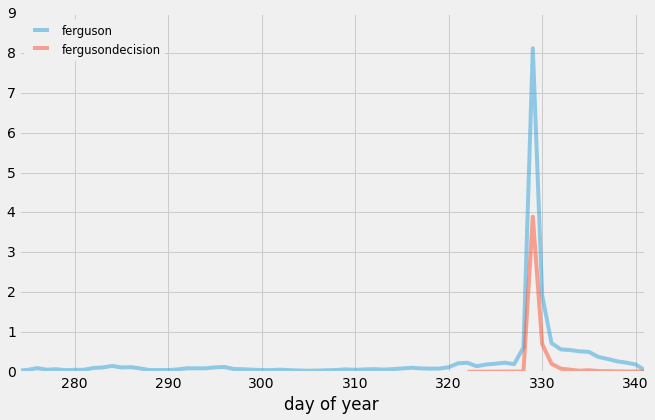

In [184]:
minmax = day_counts.select(func.min('day').alias('min'), func.max('day').alias('max')).map(lambda r: (r.min,r.max)).collect()[0]

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

def plot_hashtag_timeseries(hashtags): 
    
    if ',' in hashtags : hashtags = map(lambda x: x.strip(), hashtags.split(','))
        
    if type(hashtags) is not list:
        hashtags = [hashtags]
    max_data = 0
    for hashtag in hashtags:
        day_data = day_counts.filter(day_counts['hashtag'] == hashtag).select('day', 'count').sort('day').toPandas()
        max_data = day_data['count'].max()
        plt.plot(day_data['day'],day_data['count']/day_data['count'].std(), label = hashtag, alpha=.5)
        
    plt.xlabel('day of year')
    plt.legend(fontsize='small', loc='upper left')
    plt.xlim(minmax)
interact(plot_hashtag_timeseries, hashtags='ferguson, fergusondecision')

### Identifying hashtag trends with K-Means clustering

The lists above give us some indication of what was big news on Twitter in the last 2.5 months of 2014. We can now use a clustering approach to identify groups of hashtags that may have been a part of the same viral development. 

Spark includes a K-Means clustering algorithm in MLLib, but it doesn't take a `DataFrame` as input. Instead, we have to pass to it an `RDD` of vectors. 

In [125]:
from pyspark.mllib.linalg import SparseVector

minmax = day_counts.select(func.min('day').alias('min'), func.max('day').alias('max')).map(lambda r: (r.min,r.max)).collect()[0]

Ndays = minmax[1]-minmax[0]+1

day_counts_vec = (day_counts.select(day_counts['hashtag'], day_counts['day'], day_counts['count'].alias('counts'))
           .map(lambda r: (r.hashtag, (r.day-minmax[0], r.counts)))
           .aggregateByKey([], lambda a,b: a + [b], lambda a,b: a+b)
           .mapValues(lambda x: SparseVector(Ndays, x).toArray()))


day_counts_vec.cache()

PythonRDD[1195] at RDD at PythonRDD.scala:43

In [134]:
day_counts_filtered = day_counts_vec.filter(lambda (h,vec): vec.mean() > 10).mapValues(lambda v: v/v.std()).cache()

In [186]:
from pyspark.mllib.clustering import KMeans
model = KMeans.train(day_counts_filtered.values(), 500, runs=1, maxIterations=1000, initializationMode='random')

clusters = day_counts_filtered.mapValues(lambda vec: model.predict(vec)).cache()

In [187]:
ferguson_cluster = clusters.lookup('ferguson')[0]

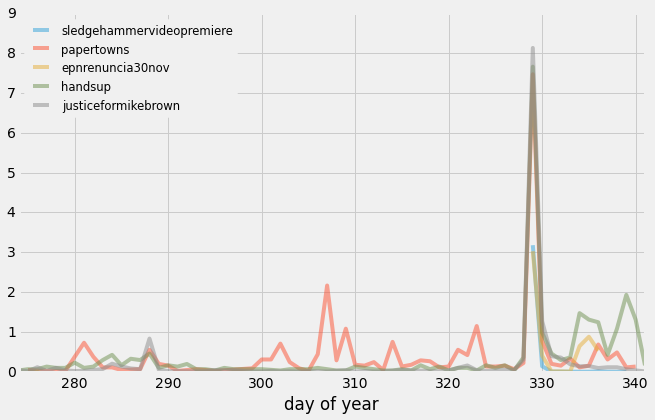

In [188]:
hashtags = clusters.filter(lambda (hashtag, cluster): cluster == ferguson_cluster).keys().takeSample(False, 5, None)
plot_hashtag_timeseries(hashtags)

In [192]:
def extract_hashtag_cluster(hashtag):
    cluster_id = clusters.lookup(hashtag)[0]
    return clusters.filter(lambda (hashtag, cluster): cluster == ferguson_cluster).keys().collect()

interact(extract_hashtag_cluster, hashtag='ferguson')

[u'camfollowme',
 u'handsup',
 u'dontsellshots',
 u'jurassicworld',
 u'followmebryant',
 u'camfoilowme',
 u'dwtsbethany',
 u'lodijocallejeros',
 u'epnrenuncia30nov',
 u'fergsuon',
 u'ferguson',
 u'eunaomereciaissoluansantana',
 u'foilowmecarter',
 u'fergusondecision',
 u'michaelbrown',
 u'followmestereokicks',
 u'prayfortrevor',
 u'nojusticenopeace',
 u'justiceformikebrown',
 u'25n',
 u'smallzywelcomeshome5sos',
 u'foilowmenash',
 u'ripmikebrown',
 u'5hsledgehammervideo',
 u'sledgehammervideopremiere',
 u'papertowns',
 u'samandskatemusic']

<function __main__.extract_hashtag_cluster>

In [198]:
clusters.first()

(u'four', 130)

In [199]:
cluster_df = clusters.toDF(['hashtag', 'cluster'])

In [200]:
cluster_df.groupBy('cluster').count().sort('cluster').show(200)

+-------+-----+
|cluster|count|
+-------+-----+
|      0|   15|
|      1|   39|
|      2|    6|
|      3|    1|
|      4|    9|
|      5|   21|
|      6|   23|
|      7|   34|
|      8|   29|
|      9|   24|
|     10|   21|
|     11|   13|
|     12|   20|
|     13|    4|
|     14|    6|
|     15|   16|
|     16|   11|
|     17|   17|
|     18|   51|
|     19|   10|
|     20|   36|
|     21|   27|
|     22|    7|
|     23|   25|
|     24|   29|
|     25|   35|
|     26|    9|
|     27|   32|
|     28|   26|
|     29|   19|
|     30|    7|
|     31|    2|
|     32|   22|
|     33|   16|
|     34|   19|
|     35|    8|
|     36|   21|
|     37|   17|
|     38|    1|
|     39|   34|
|     40|   12|
|     41|   15|
|     42|    9|
|     43|    3|
|     44|   19|
|     45|   16|
|     46|   16|
|     47|   27|
|     48|   12|
|     49|   47|
|     50|   12|
|     51|   16|
|     52|   12|
|     53|    8|
|     54|   17|
|     55|   34|
|     56|   19|
|     57|    5|
|     58|    7|
|     59

In [217]:
hashtag_list_df = (data.select('created_at', 'entities.hashtags')
                .filter(func.size('hashtags') > 0)
                .select(hash_text_udf('hashtags').alias('hashtags'), 'created_at'))

In [218]:
from pyspark.mllib.feature import Word2Vec

In [219]:
w2v = Word2Vec()

In [ ]:
model = w2v.fit(hashtag_list_df.map(lambda r:r.hashtags))